In [ ]:
import os
import numpy as np
from scipy.io import wavfile
from scipy.signal import hilbert, butter, lfilter
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# 基本設定
subject_list = ["deyama_0527", "Kawabata_0625", "uchiyama_0702", "takahashi_0710",
                "irimajiri_0807", "terazawa_1022", "fukushima_1022", "aburatani_1118", "ueno_1121"]
compare_list = ["1st", "2nd"]  # 1st: 排便前, 2nd: 排便後
add_list = ["1ch", "2ch", "3ch", "4ch"]
data_dir = "/Volumes/NO NAME/蠕動音_排便前後/"

# 基本設定
sampling_rate = 3000  # サンプリング周波数 (Hz)
segment_duration_ms = 200  # セグメント長 (ms)
backward_shift_ms = 40  # 時間軸方向と逆方向に戻る長さ (ms)
lowpass_cutoff = 400  # ローパスフィルタのカットオフ周波数 (Hz)
num_segments = 50  # セグメント数
segment_samples = int(segment_duration_ms / 1000 * sampling_rate)  # 1セグメントのサンプル数
backward_shift_samples = int(backward_shift_ms / 1000 * sampling_rate)  # 戻るサンプル数
check_start_samples = int(240 / 1000 * sampling_rate)  # 前240msに対応するサンプル数
check_end_samples = backward_shift_samples  # 前40msに対応するサンプル数
min_distance_samples = 2 * sampling_rate  # 前後5秒に対応するサンプル数

# ローパスフィルタの設計
def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = fs / 2
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return lfilter(b, a, data)

# 振幅包絡を計算する関数
def calculate_envelope(audio_data):
    analytic_signal = hilbert(audio_data)  # ヒルベルト変換
    envelope = np.abs(analytic_signal)  # 振幅包絡
    return envelope

# 特徴量抽出関数
def extract_features(segment, sampling_rate, num_bands=10, max_freq=1000):
    # RMS
    rms = np.sqrt(np.mean(segment**2))
    
    # 尖度 (Kurtosis)
    kurt = kurtosis(segment)
    
    # 歪度 (Skewness)
    skewness = skew(segment)
    
    # スペクトル重心とスペクトルロールオフ
    spectrum = np.fft.fft(segment)
    freqs = np.fft.fftfreq(len(segment), d=1/sampling_rate)
    positive_freqs = freqs[:len(freqs) // 2]
    positive_magnitude = np.abs(spectrum[:len(spectrum) // 2])
    spec_centroid = np.sum(positive_freqs * positive_magnitude) / np.sum(positive_magnitude)
    spec_rolloff = np.percentile(positive_freqs, 95)
    
    # 0-1000Hzを100Hz刻みにした帯域エネルギーを計算
    band_edges = np.arange(0, max_freq + 100, 100)
    stft_result = np.abs(np.fft.rfft(segment, n=segment_samples))**2  # パワースペクトル
    freqs_stft = np.fft.rfftfreq(segment_samples, d=1/sampling_rate)
    band_energy = []
    for i in range(len(band_edges) - 1):
        band_mask = (freqs_stft >= band_edges[i]) & (freqs_stft < band_edges[i + 1])
        band_energy.append(np.sum(stft_result[band_mask]))
    
    # 信号の振幅が閾値を超えた/下回った時間割合
    threshold = 3 * np.std(segment)
    below_duration = np.sum(segment < threshold) / sampling_rate
    above_duration = np.sum(segment >= threshold) / sampling_rate
    
    # 特徴量をまとめて返す
    return [rms, kurt, skewness, spec_centroid, spec_rolloff] + band_energy + [below_duration, above_duration]

# データ読み込みと処理
segmented_data = []  # セグメントデータを格納するリスト
labels = []  # ラベル ("before" または "after") を格納するリスト

# 除外するサンプル数の計算
exclude_start_samples = 5 * 60 * sampling_rate  # 最初5分に対応するサンプル数
exclude_end_samples = 5 * sampling_rate  # 最後5秒に対応するサンプル数

for subject in subject_list:
    for compare in compare_list:
        for channel in add_list:
            file_path = os.path.join(data_dir, f"{subject}_{compare}_{channel}_renoise.wav")
            if os.path.exists(file_path):
                _, audio_data = wavfile.read(file_path)  # WAVファイルの読み込み
                
                # 最初の5分と最後の5秒を除外
                if len(audio_data) > exclude_start_samples + exclude_end_samples:
                    audio_data = audio_data[exclude_start_samples: -exclude_end_samples]
                else:
                    print(f"File too short after exclusion: {file_path}")
                    continue
                
                # 振幅包絡を計算
                envelope = calculate_envelope(audio_data)

                # 振幅包絡がしきい値を超えた点を抽出
                threshold = np.mean(envelope) + 2 * np.std(envelope)
                significant_points = np.where(envelope > threshold)[0]
                
                if len(significant_points) > 0:
                    # 抽出した点を振幅包絡が大きい順に並べ替え
                    sorted_points = significant_points[np.argsort(envelope[significant_points])[::-1]]
                    
                    selected_points = []  # 選択されたサンプルのリスト

                    for point in sorted_points:
                        # 前240msから前40msの範囲内にピークがないか確認
                        check_start = max(0, point - check_start_samples)
                        check_end = max(0, point - check_end_samples)
                        
                        if np.all(envelope[check_start:check_end] <= threshold):
                            # 前後5秒以内に他の選択ポイントがないことを確認
                            if all(abs(point - sp) > min_distance_samples for sp in selected_points):
                                # 確認後、選択されたポイントをリストに追加
                                selected_points.append(point)

                                # 指定されたセグメントを抽出
                                start_idx = max(0, point - backward_shift_samples - segment_samples // 2)
                                end_idx = start_idx + segment_samples
                                if end_idx <= len(audio_data):
                                    segment_window = audio_data[start_idx:end_idx]
                                    
                                    # ローパスフィルタを適用
                                    filtered_segment = lowpass_filter(segment_window, lowpass_cutoff, sampling_rate)
                                    
                                    segmented_data.append(filtered_segment)  # セグメントをリストに追加
                                    labels.append("before" if compare == "1st" else "after")  # ラベルを追加
                                
                                # 50個に達したら終了
                                if len(selected_points) >= num_segments:
                                    break
            else:
                print(f"File not found: {file_path}")  # ファイルが見つからなかった場合のエラーメッセージ

# 特徴量抽出
features = np.array([extract_features(seg, sampling_rate) for seg in segmented_data])

# 特徴量のスケーリング
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# NaNを列ごとの平均値で埋める
nan_indices = np.isnan(features_scaled)
column_means = np.nanmean(features_scaled, axis=0)
features_scaled[nan_indices] = np.take(column_means, np.where(nan_indices)[1])

In [4]:
# **教師なしクラスタリング**
# クラスタリング手法と評価を設定
cluster_methods = {
    "KMeans": lambda n: KMeans(n_clusters=n, random_state=0).fit(features_scaled).labels_,
    "GaussianMixture": lambda n: GaussianMixture(n_components=n, random_state=0).fit_predict(features_scaled),
    "Ward": lambda n: AgglomerativeClustering(n_clusters=n, linkage="ward").fit_predict(features_scaled)
}

best_method, best_score, best_clusters, best_n_clusters = None, float("inf"), None, None

for method_name, cluster_func in cluster_methods.items():
    for n_clusters in range(2, 6):
        try:
            clusters = cluster_func(n_clusters)
            score = davies_bouldin_score(features_scaled, clusters)
            if score < best_score:
                best_method = method_name
                best_score = score
                best_clusters = clusters
                best_n_clusters = n_clusters
        except Exception as e:
            print(f"Error in {method_name} with n_clusters={n_clusters}: {e}")

# 結果の表示
print(f"Best Method: {best_method}")
print(f"Best Davies-Bouldin Score: {best_score}")
print(f"Optimal Number of Clusters: {best_n_clusters}")

import pandas as pd

# クラスターラベルと排便前後のラベルをデータフレームに格納
data_df = pd.DataFrame({
    'Cluster': best_clusters,
    'Label': labels  # "before" または "after" のリスト
})

# 各クラスタ内のラベル分布を集計
class_distribution = data_df.groupby(['Cluster', 'Label']).size().unstack(fill_value=0)

# 結果の出力
print("各クラス内の排便前 ('before') と排便後 ('after') のサンプル数:")
print(class_distribution)

# Optional: 各クラスの割合を計算して表示
class_distribution_percentage = class_distribution.div(class_distribution.sum(axis=1), axis=0) * 100
print("\n各クラス内の排便前 ('before') と排便後 ('after') の割合 (%):")
print(class_distribution_percentage)

/Users/a81802/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/a81802/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/a81802/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/a81802/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

Best Method: KMeans
Best Davies-Bouldin Score: 0.019223006611864726
Optimal Number of Clusters: 2
各クラス内の排便前 ('before') と排便後 ('after') のサンプル数:
Label    after  before
Cluster               
0         1659    1670
1            1       0

各クラス内の排便前 ('before') と排便後 ('after') の割合 (%):
Label         after     before
Cluster                       
0         49.834785  50.165215
1        100.000000   0.000000


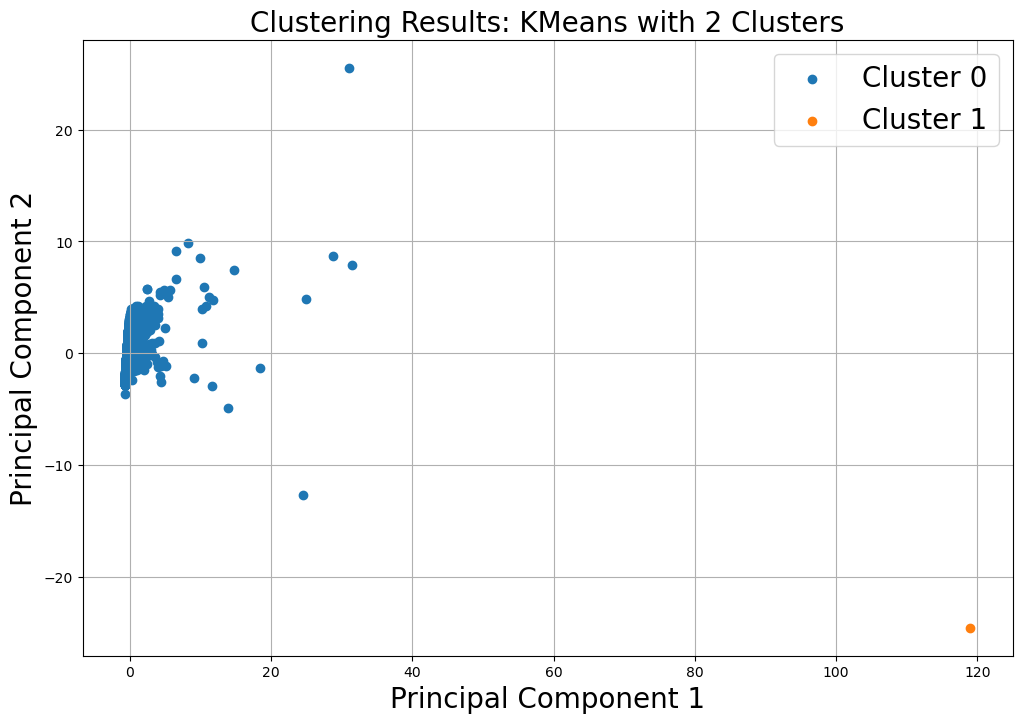


PC1 (Explained Variance: 40.05%):
Band 300-400Hz: 0.3685
Band 600-700Hz: 0.3577
Band 200-300Hz: 0.3496
Band 700-800Hz: 0.3455
Band 800-900Hz: 0.3366
Band 900-1000Hz: 0.3337
Band 500-600Hz: 0.2706
RMS: 0.2638
Band 100-200Hz: 0.2375
Band 0-100Hz: 0.2053
Band 400-500Hz: 0.1461
Above Threshold: 0.0591
Below Threshold: -0.0591
Spectral Centroid: -0.0182
Skewness: -0.0036
Kurtosis: -0.0005
Spectral Rolloff: 0.0000

PC2 (Explained Variance: 15.12%):
Above Threshold: 0.5086
Below Threshold: -0.5086
Spectral Centroid: -0.3705
RMS: 0.2718
Band 100-200Hz: 0.2642
Band 900-1000Hz: -0.1987
Band 800-900Hz: -0.1965
Band 700-800Hz: -0.1860
Band 0-100Hz: 0.1762
Band 600-700Hz: -0.1458
Skewness: -0.1136
Kurtosis: -0.0994
Band 200-300Hz: 0.0704
Band 400-500Hz: 0.0704
Band 300-400Hz: -0.0635
Band 500-600Hz: -0.0021
Spectral Rolloff: -0.0000

Number of components to explain 90% variance: 7
Cumulative Explained Variance Ratio: [0.40046137 0.55163008 0.66780695 0.76253888 0.8265943  0.88686737
 0.93546724 0.

In [45]:
# **次元削減 (PCA)**
pca = PCA(n_components=None)  # すべての成分を保持して実行
pca.fit(features_scaled)
features_2d = pca.transform(features_scaled)

# クラスタリング結果を2次元でプロット
plt.figure(figsize=(12, 8))
for cluster_id in np.unique(best_clusters):
    points = features_2d[np.array(best_clusters) == cluster_id]
    plt.scatter(points[:, 0], points[:, 1], label=f"Cluster {cluster_id}")
plt.title(f"Clustering Results: {best_method} with {best_n_clusters} Clusters", fontsize=20)
plt.xlabel("Principal Component 1", fontsize=20)
plt.ylabel("Principal Component 2", fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()

# PCAで特徴量の寄与度を解析
loadings = pca.components_  # 主成分負荷量 (shape: [n_components, n_features])
explained_variance = pca.explained_variance_ratio_  # 寄与率

# 特徴量ラベル
feature_labels = ["RMS", "Kurtosis", "Skewness", "Spectral Centroid", "Spectral Rolloff"] + \
                 [f"Band {i * 100}-{(i + 1) * 100}Hz" for i in range(10)] + \
                 ["Below Threshold", "Above Threshold"]

# PC1とPC2に寄与する特徴量を表示
for i, pc_label in enumerate(["PC1", "PC2"]):
    print(f"\n{pc_label} (Explained Variance: {explained_variance[i] * 100:.2f}%):")
    sorted_indices = np.argsort(np.abs(loadings[i]))[::-1]  # 寄与度の高い順にソート
    for idx in sorted_indices:
        print(f"{feature_labels[idx]}: {loadings[i, idx]:.4f}")

# ラベルのエンコード
y = np.array(labels)  # 「before」や「after」のリスト
y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)  # 数値に変換されたラベル

# 累積寄与率を計算
cumulative_explained_variance = np.cumsum(explained_variance)

# 70%以上の分散を説明するための成分数を決定
n_components_for_70 = np.argmax(cumulative_explained_variance >= 0.90) + 1
print(f"\nNumber of components to explain 90% variance: {n_components_for_70}")

# PCAを再度実行して、最適な成分数で次元削減
pca = PCA(n_components=n_components_for_70)
features_2d = pca.fit_transform(features_scaled)

# **PCAの結果表示**
print("Cumulative Explained Variance Ratio:", cumulative_explained_variance)

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(features_2d, y_encoded, test_size=0.2, random_state=42)

# ランダムフォレスト分類器
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# 予測結果
y_pred = clf.predict(X_test)

# 精度評価
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# 結果表示
print("Classification Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(
    n_estimators=100,       # 弱学習器の数
    learning_rate=0.1,      # 学習率
    max_depth=3,            # 各決定木の深さ
    random_state=42
)
clf.fit(X_train, y_train)

# 予測結果
y_pred = clf.predict(X_test)

# 精度評価
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# 結果表示
print("Gradient Boosting Classification Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Gradient Boosting Classification Performance:
Accuracy: 0.6201
Precision: 0.6226
Recall: 0.6201
F1 Score: 0.6180


In [22]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# 予測結果
y_pred = clf.predict(X_test)

# 精度評価
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# 結果表示
print("Gradient Boosting Classification Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Gradient Boosting Classification Performance:
Accuracy: 0.6066
Precision: 0.6067
Recall: 0.6066
F1 Score: 0.6066


In [25]:
from sklearn.ensemble import HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

# 予測結果
y_pred = clf.predict(X_test)

# 精度評価
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# 結果表示
print("Gradient Boosting Classification Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Gradient Boosting Classification Performance:
Accuracy: 0.6246
Precision: 0.6254
Recall: 0.6246
F1 Score: 0.6239


In [27]:
from xgboost import XGBClassifier
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf.fit(X_train, y_train)

# 予測結果
y_pred = clf.predict(X_test)

# 精度評価
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# 結果表示
print("Gradient Boosting Classification Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Gradient Boosting Classification Performance:
Accuracy: 0.6111
Precision: 0.6113
Recall: 0.6111
F1 Score: 0.6108


/Users/a81802/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:17:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [29]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(random_state=42)
clf.fit(X_train, y_train)

# 予測結果
y_pred = clf.predict(X_test)

# 精度評価
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# 結果表示
print("Gradient Boosting Classification Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Gradient Boosting Classification Performance:
Accuracy: 0.6306
Precision: 0.6311
Recall: 0.6306
F1 Score: 0.6302


In [4]:
# クラスタリング手法と評価を設定
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

cluster_methods = {
    "KMeans": lambda n: KMeans(n_clusters=n, random_state=0).fit(features_scaled).labels_,
    "GaussianMixture": lambda n: GaussianMixture(n_components=n, random_state=0).fit_predict(features_scaled),
    "Ward": lambda n: AgglomerativeClustering(n_clusters=n, linkage="ward").fit_predict(features_scaled)
}

best_method, best_score, best_clusters, best_n_clusters = None, float("inf"), None, None

for method_name, cluster_func in cluster_methods.items():
    for n_clusters in range(2, 6):
        try:
            clusters = cluster_func(n_clusters)
            score = davies_bouldin_score(features_scaled, clusters)
            if score < best_score:
                best_method = method_name
                best_score = score
                best_clusters = clusters
                best_n_clusters = n_clusters
        except Exception as e:
            print(f"Error in {method_name} with n_clusters={n_clusters}: {e}")

# 結果の表示
print(f"Best Method: {best_method}")
print(f"Best Davies-Bouldin Score: {best_score}")
print(f"Optimal Number of Clusters: {best_n_clusters}")

# Calinski-Harabaszスコアを計算
ch_score = calinski_harabasz_score(features_scaled, best_clusters)
print(f"Calinski-Harabasz Score: {ch_score:.2f}")

# Silhouetteスコアを計算
sil_score = silhouette_score(features_scaled, best_clusters)
print(f"Silhouette Score: {sil_score:.2f}")

import pandas as pd

# クラスターラベルと排便前後のラベルをデータフレームに格納
data_df = pd.DataFrame({
    'Cluster': best_clusters,
    'Label': labels  # "before" または "after" のリスト
})

# 各クラス内のラベル分布を集計
class_distribution = data_df.groupby(['Cluster', 'Label']).size().unstack(fill_value=0)

# 結果の出力
print("各クラス内の排便前 ('before') と排便後 ('after') のサンプル数:")
print(class_distribution)

# Optional: 各クラスの割合を計算して表示
class_distribution_percentage = class_distribution.div(class_distribution.sum(axis=1), axis=0) * 100
print("\n各クラス内の排便前 ('before') と排便後 ('after') の割合 (%):")
print(class_distribution_percentage)

/Users/a81802/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/a81802/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/a81802/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/a81802/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

Best Method: KMeans
Best Davies-Bouldin Score: 0.019223006611864726
Optimal Number of Clusters: 2
Calinski-Harabasz Score: 1364.39
Silhouette Score: 0.97
各クラス内の排便前 ('before') と排便後 ('after') のサンプル数:
Label    after  before
Cluster               
0         1659    1670
1            1       0

各クラス内の排便前 ('before') と排便後 ('after') の割合 (%):
Label         after     before
Cluster                       
0         49.834785  50.165215
1        100.000000   0.000000


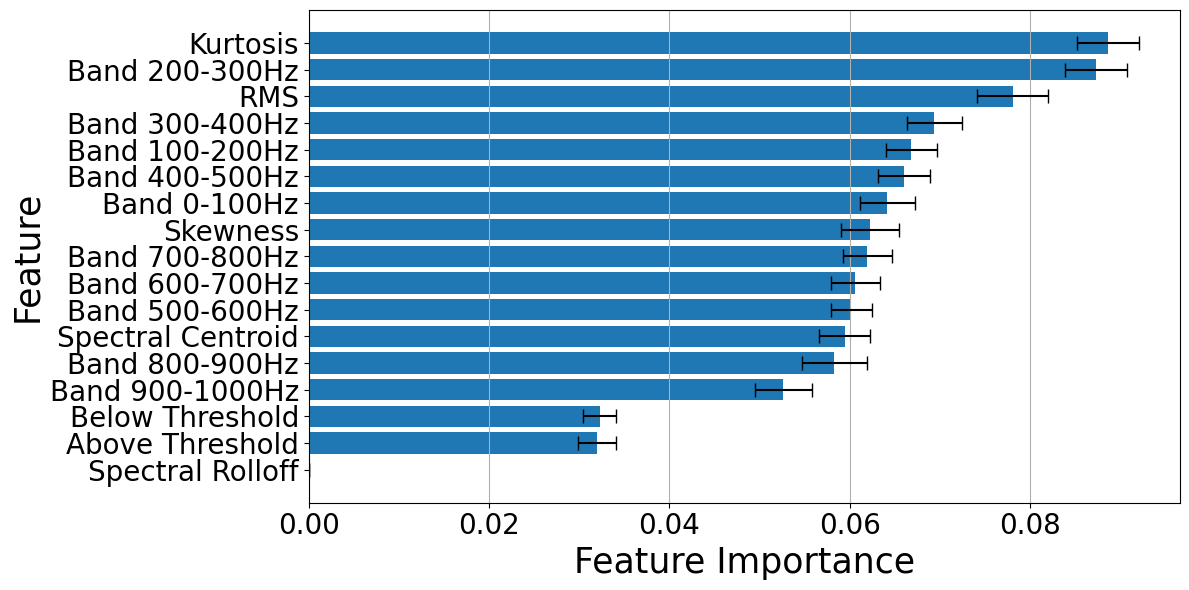

In [5]:
# **特徴量重要度のブートストラップ分析**
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
# パラメータ設定
n_bootstraps = 100  # ブートストラップの回数

# 特徴量重要度を記録するリスト
importances_list = []

# ブートストラップサンプリングを繰り返しランダムフォレストを学習
for _ in range(n_bootstraps):
    X_resampled, y_resampled = resample(features_scaled, y_encoded)  # 元の特徴量を使用
    clf_bootstrap = RandomForestClassifier(random_state=42)
    clf_bootstrap.fit(X_resampled, y_resampled)
    importances_list.append(clf_bootstrap.feature_importances_)

# 各特徴量の平均と標準偏差を計算
importances_mean = np.mean(importances_list, axis=0)
importances_std = np.std(importances_list, axis=0)

# 小さい順にソート
sorted_indices = np.argsort(importances_mean)
sorted_labels = [feature_labels[i] for i in sorted_indices]
sorted_importances = importances_mean[sorted_indices]
sorted_std = importances_std[sorted_indices]

# 重要度のプロット（エラーバー付き）
plt.figure(figsize=(12, 6))
plt.barh(sorted_labels, sorted_importances, xerr=sorted_std, align='center', capsize=5)
plt.xlabel("Feature Importance", fontsize=25)
plt.ylabel("Feature", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

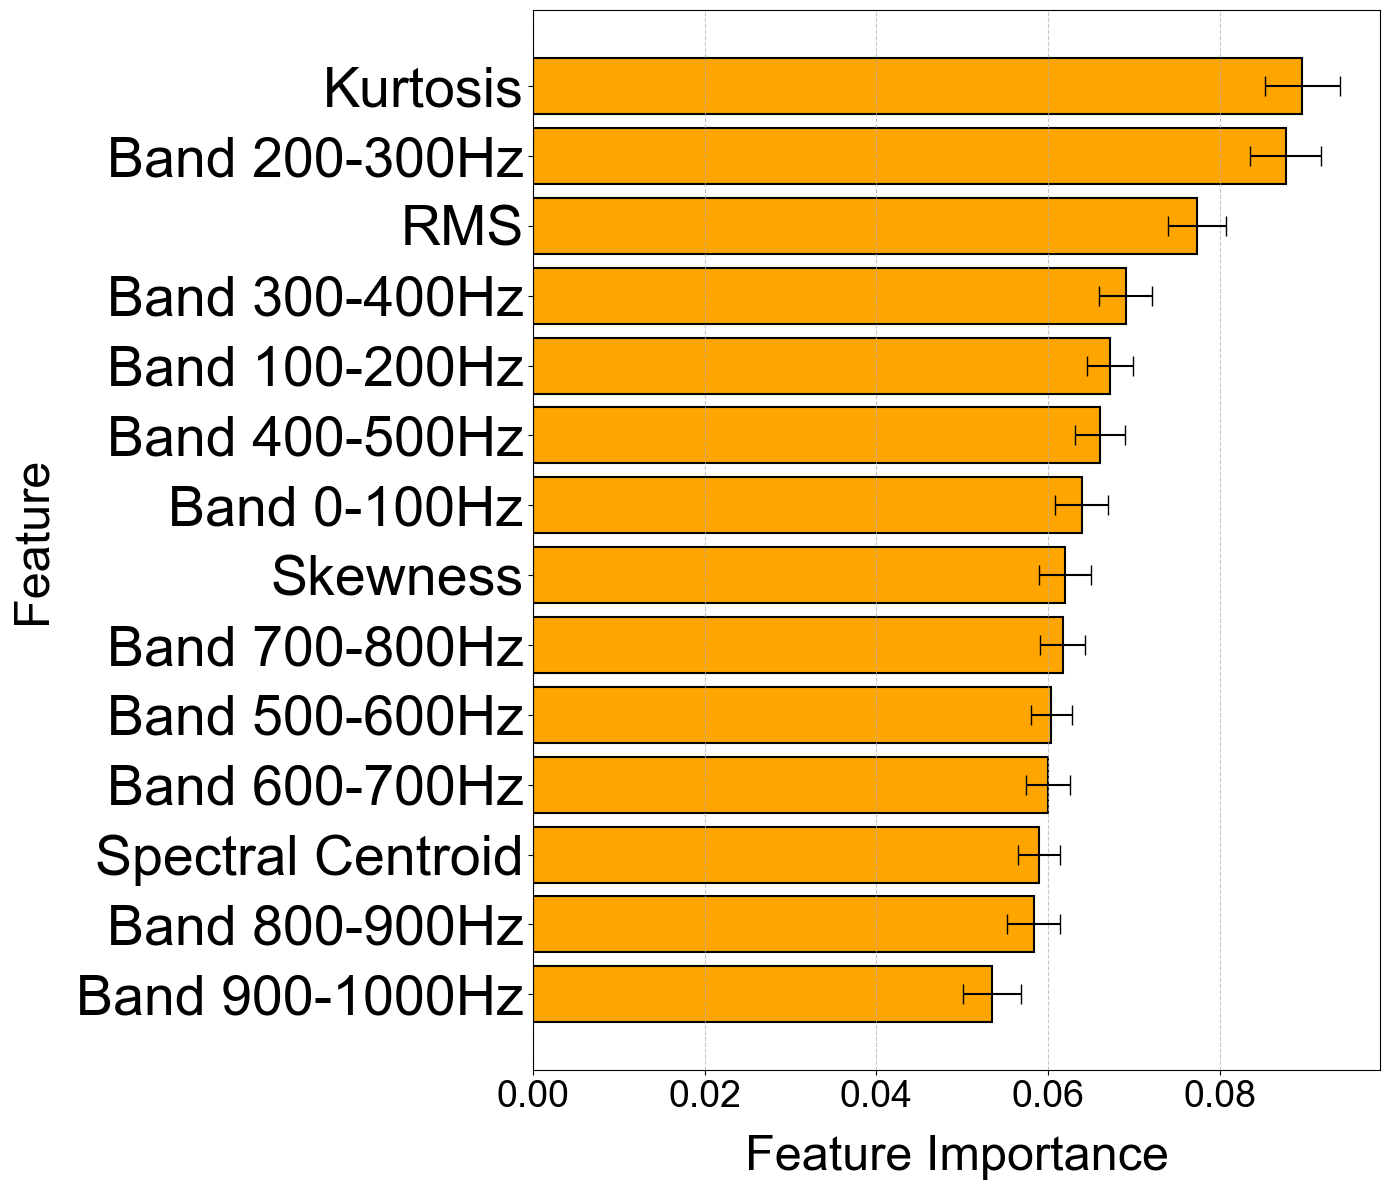

In [6]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# **特徴量重要度のブートストラップ分析**
# パラメータ設定
n_bootstraps = 100  # ブートストラップの回数

# 特徴量重要度を記録するリスト
importances_list = []

# ブートストラップサンプリングを繰り返しランダムフォレストを学習
for _ in range(n_bootstraps):
    X_resampled, y_resampled = resample(features_scaled, y_encoded)  # 元の特徴量を使用
    clf_bootstrap = RandomForestClassifier(random_state=42)
    clf_bootstrap.fit(X_resampled, y_resampled)
    importances_list.append(clf_bootstrap.feature_importances_)

# 各特徴量の平均と標準偏差を計算
importances_mean = np.mean(importances_list, axis=0)
importances_std = np.std(importances_list, axis=0)

# 重要度が0.05を超えたものをフィルタ
threshold = 0.05
filtered_indices = np.where(importances_mean > threshold)[0]
filtered_labels = [feature_labels[i] for i in filtered_indices]
filtered_importances = importances_mean[filtered_indices]
filtered_std = importances_std[filtered_indices]

# 小さい順にソート
sorted_indices = np.argsort(filtered_importances)
sorted_labels = [filtered_labels[i] for i in sorted_indices]
sorted_importances = filtered_importances[sorted_indices]
sorted_std = filtered_std[sorted_indices]

# フォント設定をArialに変更
rcParams['font.family'] = 'Arial'

# 重要度のプロット（エラーバー付き）
plt.figure(figsize=(14, 12))
plt.barh(
    sorted_labels, 
    sorted_importances, 
    xerr=sorted_std, 
    align='center', 
    capsize=7,  # エラーバーの端のキャップサイズ
    color='Orange', 
    edgecolor='black', 
    linewidth=1.5
)

# 軸ラベルとフォントサイズ
plt.xlabel("Feature Importance", fontsize=35, labelpad=15)
plt.ylabel("Feature", fontsize=35, labelpad=15)

# 軸の目盛りフォントサイズ
plt.xticks(fontsize=27)
plt.yticks(fontsize=40)

# グリッド線をx軸に追加
plt.grid(axis='x', linestyle='--', alpha=0.7)

# レイアウト調整
plt.tight_layout()

# グラフの表示
plt.show()

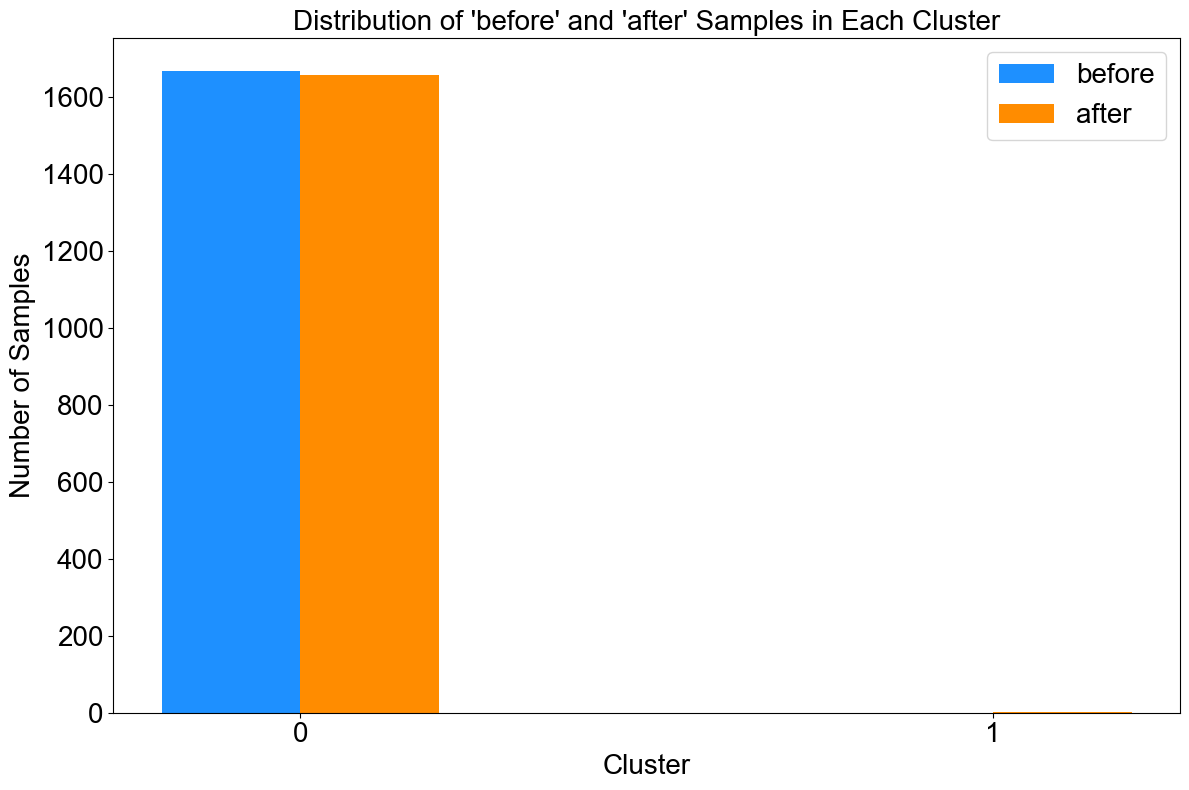

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# データ準備
clusters = class_distribution.index
before_counts = class_distribution['before']
after_counts = class_distribution['after']

# 棒の幅を調整（間隔を狭くする）
bar_width = 0.1
x = np.array([1.0,1.5])  # クラスターの位置

# グラフのプロット
plt.figure(figsize=(12, 8))
plt.bar(x - bar_width / 2, before_counts, width=bar_width, color='dodgerblue', label='before')
plt.bar(x + bar_width / 2, after_counts, width=bar_width, color='darkorange', label='after')

# 軸ラベルとタイトルの設定
plt.xlabel("Cluster", fontsize=20)
plt.ylabel("Number of Samples", fontsize=20)
plt.title("Distribution of 'before' and 'after' Samples in Each Cluster", fontsize=20)
plt.xticks(x, clusters, fontsize=20)  # クラスター位置にラベルを設定
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.tight_layout()

plt.show()